# Aircraft atmospheric CO<sub>2</sub> profiles

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import datasets
import emergent_constraint as ec
import figure_panels
import util

## Identify models

In [3]:
model_input_lists = ec.get_model_tracer_lists('ocean_constraint')
model_list_profile_comparison = []
for m, t in model_input_lists['model_tracer_list']:
    if not any(s in m for s in ['TM5', 'CESM', 'prior']) and m not in model_list_profile_comparison:
        model_list_profile_comparison.append(m)
model_list_profile_comparison

['CT2017',
 'CT2019B',
 'CTE2018',
 'CTE2020',
 'MIROC',
 'CAMSv20r1',
 's99oc_v2020',
 's99oc_ADJocI40S_v2020',
 's99oc_SOCCOM_v2020']

## Compute profiles

In [4]:
%%time
dsets_seas = {}
coord = 'theta'
seasonal_groups = ['DJF', 'MAM', 'JJA', 'SON']
for model in ['obs'] + model_list_profile_comparison:
    tracers = ['CO2'] if model == 'obs' else ['CO2', 'CO2_LND', 'CO2_FFF']
    for tracer in tracers:
        key = f'{model}-{coord}-{tracer}'
        dsets_seas[key] = datasets.aircraft_profiles_seasonal(
            source=model,
            tracer=tracer,
            seasonal_groups=seasonal_groups,
            clobber=False,
        )
dsets_seas['obs-theta-CO2']           

CPU times: user 439 ms, sys: 53.9 ms, total: 493 ms
Wall time: 1.07 s


<xarray.Dataset>
Dimensions:              (season: 4, theta: 11)
Coordinates:
  * season               (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
  * theta                (theta) float64 270.0 275.0 280.0 ... 310.0 315.0 320.0
Data variables: (12/135)
    ch4                  (season, theta) float64 -1.691 -1.112 ... -1.277 -8.285
    ch4_med              (season, theta) float64 -1.625 -0.805 ... 0.9865 -13.22
    ch4_med_std          (season, theta) float64 0.557 1.139 ... 11.36 19.76
    ch4_std              (season, theta) float64 -0.5766 -0.5704 ... 2.321 5.563
    ch4_std_std          (season, theta) float64 0.09758 0.2406 ... 2.37 4.173
    ch4mpanther          (season, theta) float64 nan 3.895 ... -1.017 -3.213
    ...                   ...
    sf6ucats_std_std     (season, theta) float64 nan 0.02498 ... 0.009239
    strat                (season, theta) float64 0.0 0.0 0.0 ... 0.2142 0.5099
    strat_med            (season, theta) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.5
    strat_med_std        (season, theta) float64 0.0 0.0 0.0 ... 0.3796 0.4841
    strat_std            (season, theta) float64 0.0 0.0 0.0 ... 0.1769 0.1614
    strat_std_std        (season, theta) float64 0.0 0.0 0.0 ... 0.2364 0.2356

## Visualize profiles

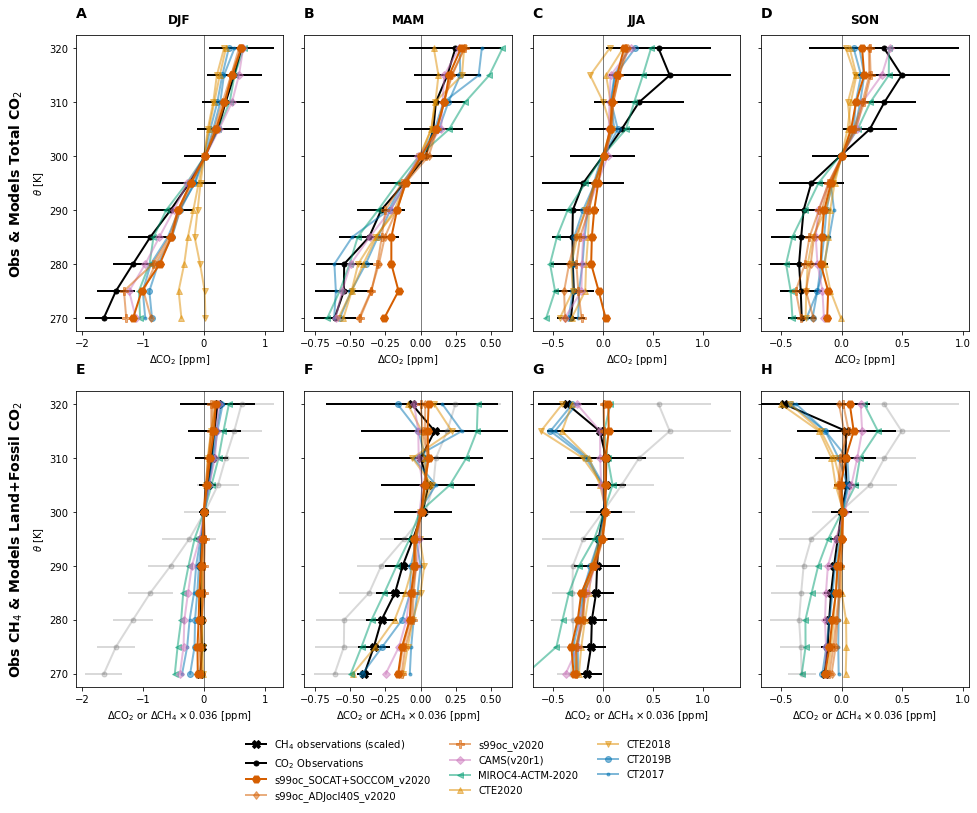

In [5]:
field = 'co2'
slope = 0.036

ds_obs = dsets_seas['obs-theta-CO2']
theta = ds_obs.theta
seasons = ds_obs.season.values

colors = figure_panels.palette_colors

fig, axs = util.canvas(2, len(seasonal_groups), figsize=(4, 6), use_gridspec=True, wspace=0.1)
marker_spec = figure_panels.marker_spec_models()

xlm = []
for row in range(2):
    for n, season in enumerate(seasonal_groups):
        i, j = np.unravel_index(n+row*len(seasonal_groups), axs.shape)

        ax = axs[i, j]
        dsi = ds_obs.sel(season=season)
        
        color = 'k' if i == 0 else 'dimgray'
        alpha = 1 if i == 0 else 0.25
        
        x, xerr = np.array(dsi[f'{field}_med'].values), np.array(dsi[f'{field}_med_std'].values)
        ax.errorbar(x, theta, xerr=xerr, 
                    c=color, 
                    marker='.', 
                    label='CO$_2$ Observations',
                    alpha=alpha,
                    lw=2, 
                    markersize=10, 
                    zorder=-100)

        if i == 1:
            xo, xoerr = np.array(dsi[f'ch4_med'].values) * slope, np.array(dsi[f'ch4_med_std'].values) * slope   
            ax.errorbar(xo, theta, xerr=xoerr, c='k', marker='X', 
                        label='CH$_4$ observations (scaled)',
                        lw=2, markersize=8, zorder=-100)

        xavg = np.zeros((len(theta),))
        nmodel = 0
        for m in model_list_profile_comparison:
            if i == 0:
                key = f'{m}-theta-CO2'
                dsi = dsets_seas[key].sel(season=season)
                x, xerr = np.array(dsi[f'{field}_med'].values), np.array(dsi[f'{field}_med_std'].values)

            else:
                key = f'{m}-theta-CO2_LND'
                if key not in dsets_seas:
                    continue
                dsi = dsets_seas[key].sel(season=season)
                x, xerr = np.array(dsi[f'{field}_med'].values), np.array(dsi[f'{field}_med_std'].values)

                key = f'{m}-theta-CO2_FFF'
                dsi = dsets_seas[key].sel(season=season)
                x2, xerr2 = np.array(dsi[f'{field}_med'].values), np.array(dsi[f'{field}_med_std'].values)
    
                x += x2
        
            zorder = 100 if 'SOCCOM' in m else None                
            alpha = 1. if 'SOCCOM' in m else 0.5                            
            ax.plot(x, theta, lw=2, alpha=alpha, zorder=zorder, **marker_spec[m]['CO2'])

        ax.axvline(0., lw=0.5, c='k')
        if i == 0:
            ax.set_title(season, fontweight='bold', y=1.02)
            #ax.set_title('Obs and models: Total CO$_2$')
            ax.set_xlabel(f'$\Delta$CO$_2$ [ppm]')
        else:
            ax.set_xlabel(f'$\Delta$CO$_2$ or $\Delta$CH$_4 \\times {slope:0.3f}$ [ppm]')
            #ax.set_title('Obs CH$_4$ & Models LND+FF CO$_2$')
        #ax.set_xlim(xlm)
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('$\\theta$ [K]')
        if i == 0:
            xlm.append(ax.get_xlim())
        else:
            ax.set_xlim(xlm[j])
h0, l0 = axs[0, 0].get_legend_handles_labels()
h1, l1 = axs[-1, -1].get_legend_handles_labels()
h = h0 + h1
l = l0 + l1
_, I = np.unique(l, return_index=True)
I.sort()
h = [h[i] for i in I]
l = [l[i] for i in I]
axs[-1, -1].legend(h[::-1], l[::-1], loc=(-2.5, -0.4), ncol=3, frameon=False);

util.subplot_row_labels(axs[:, 0], ['Obs & Models Total CO$_2$', 'Obs CH$_4$ & Models Land+Fossil CO$_2$'])

util.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.0)

util.savefig(f'profiles-bottomrow-fff+lnd.pdf')